In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

DFT = '#67568c'
PRE_TRAIN = "orange"
FINE_TUNE = '#ff6e6c'

In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# Summary Error Plot

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from digital_experiments import all_experiments, convert_to_experiments
from scripts.optimize_le import space as le_optimisation_space


df = all_experiments("../experiment-logs/pre-train")
experiments = convert_to_experiments(df)

config = list(le_optimisation_space)
other_config = set(experiments[0].config) - set([*config, "fold"])

config = ["config."+c for c in config]
other_config = ["config."+c for c in other_config]

results = ["results." + r for r in ["fine_tune.structure.rmse.test", "fine_tune.structure.rmse.val", "fine_tune.structure.rmse.train", "pretrain.structure.rmse.test", "pretrain.structure.rmse.val", "pretrain.structure.rmse.train"]]


results = df.drop(columns=other_config).groupby(config)[results].agg(['mean', 'std']).reset_index(drop=True)

best_pretraining = results.sort_values(("results.fine_tune.structure.rmse.val", "mean")).iloc[0]
best_pretraining

/opt/miniconda3/envs/fine-tune/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


results.fine_tune.structure.rmse.test   mean    2.650871
                                        std     0.250519
results.fine_tune.structure.rmse.val    mean    2.651042
                                        std     0.140497
results.fine_tune.structure.rmse.train  mean    1.466211
                                        std     0.313441
results.pretrain.structure.rmse.test    mean    4.522203
                                        std     0.761285
results.pretrain.structure.rmse.val     mean    4.532717
                                        std     0.762207
results.pretrain.structure.rmse.train   mean    4.462459
                                        std     0.767274
Name: 35, dtype: float64

Best model config

In [5]:
all_config = [*config, *other_config]
results = df.groupby(all_config).mean()
results.reset_index().sort_values("results.fine_tune.structure.rmse.val").iloc[0][all_config]

/var/folders/g9/k2dyt0ls1lzgtl01g3cm11r00000gr/T/ipykernel_69677/680421227.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results = df.groupby(all_config).mean()


config.pre_lr                         0.001
config.pre_weight_decay            0.000001
config.pre_dropout                      0.5
config.pre_epochs                        -1
config.lr                            0.0001
config.weight_decay                     0.0
config.dropout                         0.05
config.hidden_size                      400
config.n_layers                           3
config.n_train                           -1
config.optimizer                      AdamW
config.n_max                              8
config.pre_structures_per_batch          20
config.structures_per_batch             200
config.activation                      CELU
config.l_max                              8
Name: 35, dtype: object

In [6]:
from scripts.optimize_dft import space as dft_optimisation_space

df = all_experiments("../experiment-logs/train-on-dft")
experiments = convert_to_experiments(df)

config = list(dft_optimisation_space)
other_config = list(set(experiments[0].config) - set([*config, "fold"]))

config = ["config."+c for c in config]
other_config = ["config."+c for c in other_config]

results = ["results." + r for r in ["structure.rmse.test", "structure.rmse.val", "structure.rmse.train"]]

results = df.drop(columns=other_config).groupby(config)[results].agg(['mean', 'std']).reset_index(drop=True)

best_dft = results.sort_values(("results.structure.rmse.val", "mean")).iloc[0]
best_dft

results.structure.rmse.test   mean    3.288801
                              std     0.161811
results.structure.rmse.val    mean    3.259191
                              std     0.158453
results.structure.rmse.train  mean    1.160071
                              std     0.328863
Name: 12, dtype: float64

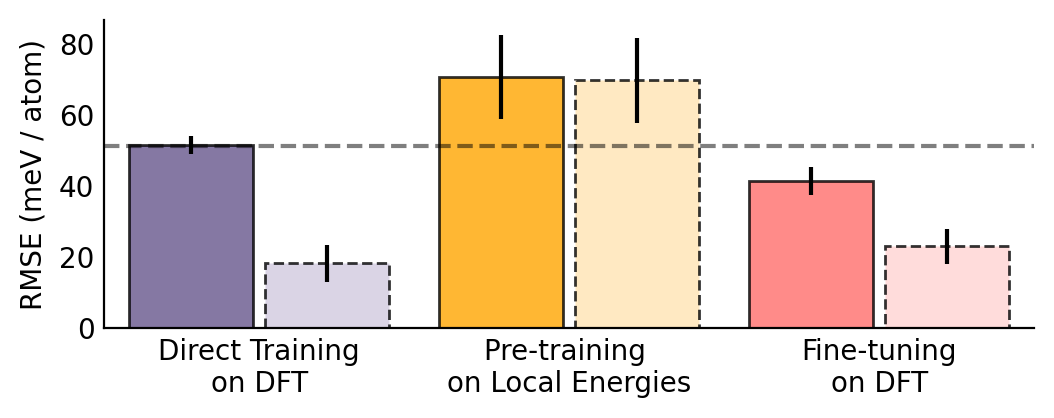

In [7]:
import matplotlib.pyplot as plt
from functools import partial
%config InlineBackend.figure_format = 'retina'

# ticks = [0, 1.3, 2.3]
ticks = np.array([0, 1, 2])
x = ["Direct Training\non DFT", "Pre-training \non Local Energies", "Fine-tuning\non DFT"]

ys = [1000 * best_dft['results.structure.rmse.test'] / 64, 1000 * best_pretraining['results.pretrain.structure.rmse.test'] / 64, 1000 * best_pretraining['results.fine_tune.structure.rmse.test'] / 64]


plt.figure(figsize=(6, 2))
for i, t in enumerate(("train", "test")):
    ys = [1000 * best_dft[f'results.structure.rmse.{t}'] / 64, 1000 * best_pretraining[f'results.pretrain.structure.rmse.{t}'] / 64, 1000 * best_pretraining[f'results.fine_tune.structure.rmse.{t}'] / 64]

    plt.bar(ticks - 0.22 * 2 * (i-0.5), [_y['mean'] for _y in ys], yerr=[_y['std'] for _y in ys], color=[*map(partial(lighten_color, amount=0.3), [DFT, PRE_TRAIN, FINE_TUNE])] if not i else [DFT, PRE_TRAIN, FINE_TUNE], width=0.4, edgecolor="black", linestyle="-" if i else "--", alpha=0.8)

plt.ylabel("RMSE (meV / atom)")
plt.xticks(ticks, x)

for s in ['top', 'right']:
    plt.gca().spines[s].set_visible(False)
plt.xlim(-0.5, ticks[-1] + 0.5)

plt.gca().tick_params(axis=u'both', which=u'both',length=0)

plt.axhline(3.28 / 64 * 1000, color="black", linestyle="--", alpha=0.5)

plt.savefig("comparison.png", bbox_inches="tight", dpi=200)

# Parity Plots

In [8]:
import torch
from src.data import sum_along, naïve_cv, get_data, shape_preserving_scaler
from src.nn import NeuralNetwork
from digital_experiments import get_artefacts

soaps, dft_energies, local_energies, _ = get_data(8, 8)
# shuffle and split data according to a naive CV policy
X, y_dft, y_local = naïve_cv(
    soaps,
    dft_energies,
    local_energies,
    n_train=-1,
    fold=0,
)

X = X | shape_preserving_scaler(X.train)

def plot(root, experiment_id, model_location="best.ckpt", axs=None, N=1_000, color="black", **kwargs):
    location = get_artefacts(root, experiment_id)[model_location]
    model = NeuralNetwork.load_from_checkpoint(location)
    model.eval()

    with torch.no_grad():
        local_preds = X | torch.FloatTensor | model | np.array
    dft_preds = local_preds | sum_along(axis=1)

    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    test_idxs = np.random.RandomState(42).choice(len(y_local.test.reshape(-1)), size=N, replace=False)
    axs[0].scatter(y_local.test.reshape(-1)[test_idxs] - 157, local_preds.test.reshape(-1)[test_idxs] - 157, color=color, linewidths=0, **kwargs)
    axs[0].set_aspect("equal")
    axs[0].set_xlim(-159, -153.5)
    axs[0].set_ylim(-159, -153.5)


In [9]:
from digital_experiments import all_experiments

template = {
    "n_max": 8,
    "l_max": 8,
}

df = all_experiments("../experiment-logs/pre-train", template)
experiments = convert_to_experiments(df)

config = list(le_optimisation_space)
other_config = list(set(experiments[0].config) - set([*config, "fold"]))

config = ["config." + c for c in config]
other_config = ["config." + c for c in other_config]

results = df.drop(columns=other_config).groupby(config).mean().drop(columns=["config.fold"]).reset_index()
best_config = dict(results.sort_values("results.fine_tune.structure.rmse.val")[config].iloc[0])
best_config

/var/folders/g9/k2dyt0ls1lzgtl01g3cm11r00000gr/T/ipykernel_69677/1880042407.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results = df.drop(columns=other_config).groupby(config).mean().drop(columns=["config.fold"]).reset_index()


{'config.pre_lr': 0.001,
 'config.pre_weight_decay': 1e-06,
 'config.pre_dropout': 0.5,
 'config.pre_epochs': -1.0,
 'config.lr': 0.0001,
 'config.weight_decay': 0.0,
 'config.dropout': 0.05,
 'config.hidden_size': 400.0,
 'config.n_layers': 3.0}

In [10]:
best_pre_train_experiment = df.copy()

for c in config:
    best_pre_train_experiment = best_pre_train_experiment[best_pre_train_experiment[c] == best_config[c]]

best_pre_train_experiment = best_pre_train_experiment.sort_values("results.pretrain.structure.rmse.val")
best_pre_train_experiment = best_pre_train_experiment.iloc[0].id
best_pre_train_experiment

'221027-113820-9983-pure-hide'

In [11]:
df = all_experiments("../experiment-logs/train-on-dft", template, metadata=True)
experiments = convert_to_experiments(df)

config = list(dft_optimisation_space)
other_config = list(set(experiments[0].config) - set([*config, "fold"]))

config = ["config." + c for c in config]
other_config = ["config." + c for c in other_config]

results = df.drop(columns=other_config).groupby(config).mean().drop(columns=["config.fold"]).reset_index()
best_config = dict(results.sort_values("results.structure.rmse.val")[config].iloc[0])
best_config

/var/folders/g9/k2dyt0ls1lzgtl01g3cm11r00000gr/T/ipykernel_69677/2383547579.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results = df.drop(columns=other_config).groupby(config).mean().drop(columns=["config.fold"]).reset_index()


{'config.lr': 8.577189481714394e-05,
 'config.weight_decay': 0.0009182542835656,
 'config.dropout': 0.0512,
 'config.hidden_size': 665,
 'config.n_layers': 4,
 'config.activation': 'CELU',
 'config.structures_per_batch': 14}

In [12]:
best_dft_train_experiment = df.copy()

for c in config:
    best_dft_train_experiment = best_dft_train_experiment[best_dft_train_experiment[c] == best_config[c]]

best_dft_train_experiment = best_dft_train_experiment.sort_values("results.structure.rmse.val")
best_dft_train_experiment = best_dft_train_experiment.iloc[0].id
best_dft_train_experiment

'221026-042853-0943-zany-farm'

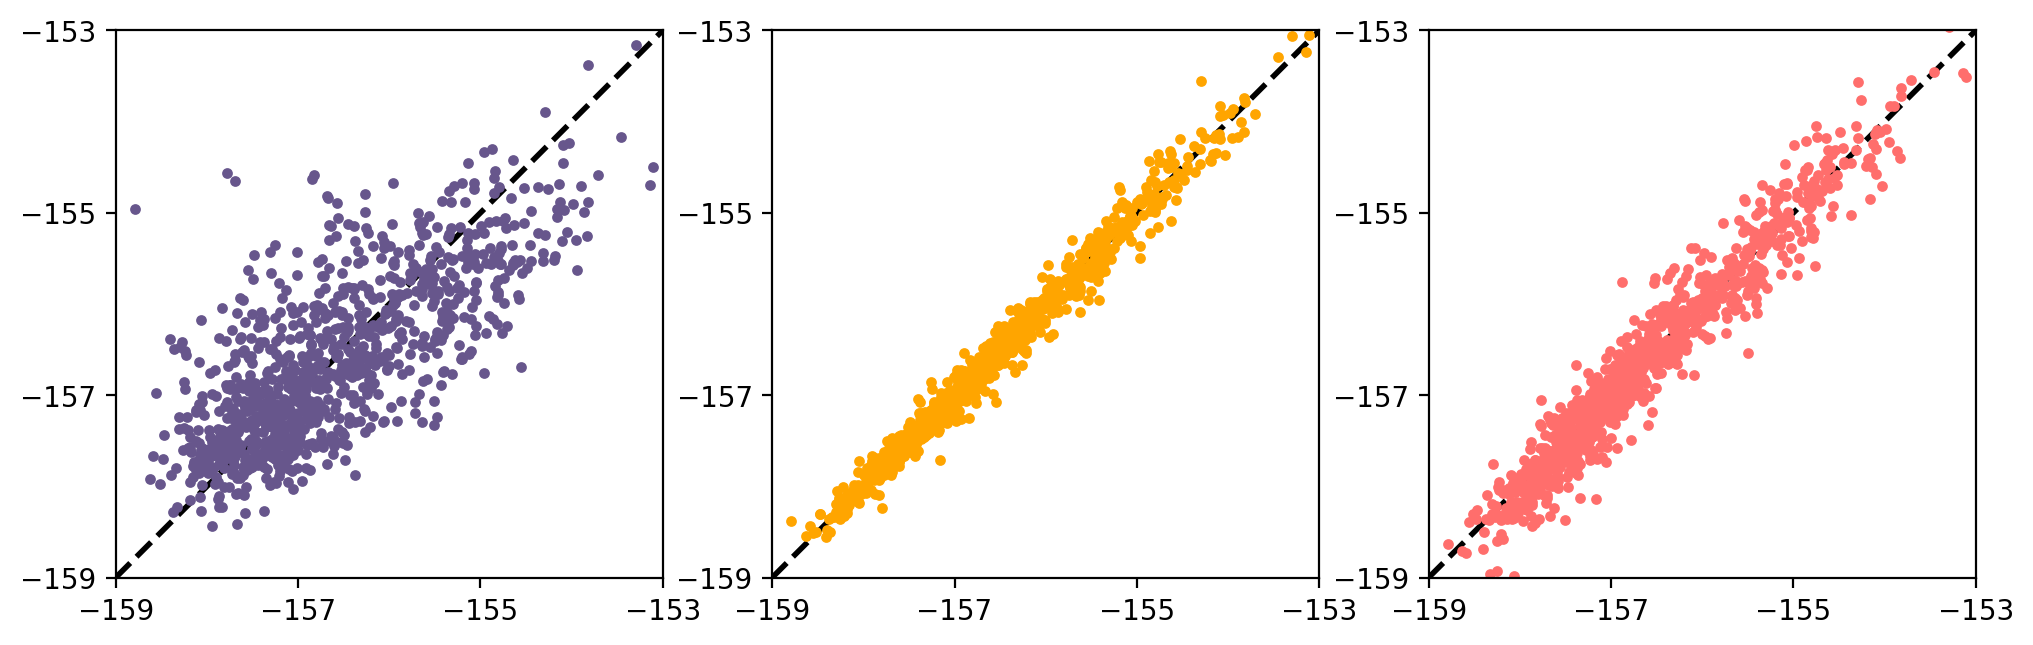

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

s = 15
N = 1_000
alpha = 1
plot("../experiment-logs/train-on-dft", best_dft_train_experiment, axs=[axs[0]], N=N, color=DFT, s=s, alpha=alpha)
plot("../experiment-logs/pre-train", best_pre_train_experiment, "best.ckpt", axs=[axs[1]], N=N, color=PRE_TRAIN, s=s, alpha=alpha)
plot("../experiment-logs/pre-train", best_pre_train_experiment, "best-v1.ckpt", axs=[axs[2]], N=N, color=FINE_TUNE, s=s, alpha=alpha)

for ax in axs:
    ticks = [-159, -157, -155, -153]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.axline((-157, -157), slope=1, color="black", linewidth=2, linestyle="--", zorder=-1)

plt.savefig("parity-plots.png", bbox_inches="tight", dpi=200)